In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import sklearn as skl
import sklearn.model_selection as skl_ms
import seaborn as sns
import cv2
from PIL import Image
import tensorflow_addons as tfa

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

tfk = tf.keras
tfkl = tf.keras.layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
dataframe = pd.read_csv('/kaggle/input/quality-annotated-dataframe/quality_annotated_dataframe.csv')

In [5]:
dataframe_quality = dataframe[dataframe['quality'] == 0]

filenames = dataframe_quality['file'].to_numpy()
to_remove = np.zeros(filenames.shape[0])

num_duplicates = 0

# Let's remove duplicates
for index in range(filenames.shape[0]):
    # Ignore the last element
    if index == filenames.shape[0] - 1:
        break
    
    filename = filenames[index]
    next_filename = filenames[index + 1]
    
    # Remove extension
    filename = filename.replace('.png', '')
    filename = filename.replace('.jpeg', '')
    next_filename = next_filename.replace('.png', '')
    next_filename = next_filename.replace('.jpeg', '')
    
    # If consecutive filenames refer to the same patient
    if filename[:-2] == next_filename[:-2]:
        to_remove[index + 1] = 1
        num_duplicates = num_duplicates + 1
        index = index + 1
        
dataframe_quality = dataframe_quality[to_remove == 0]
        
print('Removed %d duplicates' % num_duplicates)

dataframe_path = dataframe_quality.copy()
dataframe_path['path'] = '/kaggle/input/training-dataset/train/' + dataframe_path['label'] + '/' + dataframe_path['file']

Removed 1293 duplicates


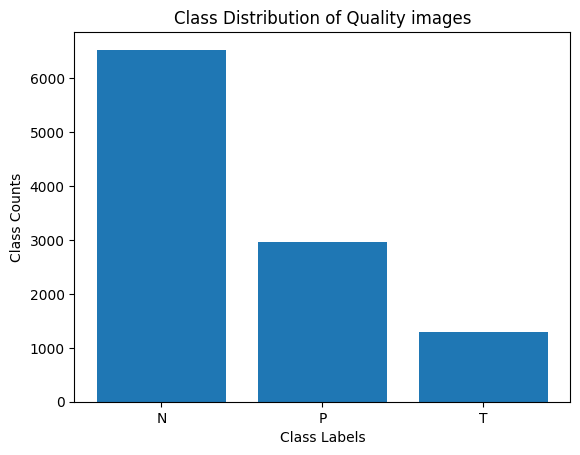

In [6]:
labels = dataframe_path['label']

# Create a bar plot
plt.bar(np.unique(labels), [np.sum(labels == l) for l in np.unique(labels)])

# Add labels and title to the plot
plt.xlabel('Class Labels')
plt.ylabel('Class Counts')
plt.title('Class Distribution of Quality images')

# Display the plot
plt.show()

In [7]:
seed = 451857256
train_path_based, test_path_based = train_test_split(dataframe_path,random_state = seed, test_size=0.2, shuffle=True)
train_path_based, validation_path_based = train_test_split(train_path_based, random_state=seed, test_size=0.1, shuffle=True)

In [8]:
def preprocessing(image):
    if image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = np.uint8(image)

    # Check if background is Standard Radiological Format compliant, otherwise invert colors
    # (the check is performed on the median color along the spine)
    buffer = image / np.max(image)

    median_spine = np.median(buffer[:, buffer.shape[1] // 2])

    if median_spine < 0.5:
        image = cv2.bitwise_not(image)

    # Mist reduction and gamma transformation
    img_equalized = cv2.equalizeHist(image)
    gamma = 1.5
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                    for i in np.arange(0, 256)]).astype('uint8')
    img_gamma = cv2.LUT(img_equalized, table)

    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img_gamma)

    # Apply Gaussian Smoothing
    gaussian_img = cv2.GaussianBlur(clahe_img, (5,5), 0)
    gaussian_img = gaussian_img.reshape(gaussian_img.shape[0], gaussian_img.shape[1], 1)
    
    # Need to duplicate channel to make it RGB to use a pretrained model
    rgb_duplicated = np.repeat(gaussian_img, repeats=3, axis=-1)
    
    # Specific preprocessing from densenet
    rescaled = tfk.applications.densenet.preprocess_input(rgb_duplicated)
    
    return rescaled

In [9]:
root_dir = '/kaggle/input/normalpneumoniatubeculosis-qualityannotated'

train_datagen = ImageDataGenerator(preprocessing_function=preprocessing)
# Use flow_from_dataframe method to read images from directory based on dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_path_based,
    directory=root_dir,
    x_col='path',
    y_col='label',
    target_size=(512, 512), # set the target image size
    batch_size=64, # set the batch size
    class_mode='categorical' # set the class mode to categorical for multi-class classification
)


validation_datagen = ImageDataGenerator(preprocessing_function=preprocessing)

# Use flow_from_dataframe method to read images from directory based on dataframe
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_path_based,
    directory=root_dir,
    x_col='path',
    y_col='label',
    shuffle = False,
    target_size=(512, 512), # set the target image size
    batch_size=64, # set the batch size
    class_mode='categorical' # set the class mode to categorical for multi-class classification
)


test_datagen = ImageDataGenerator(preprocessing_function=preprocessing)

# Use flow_from_dataframe method to read images from directory based on dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_path_based,
    directory=root_dir,
    x_col='path',
    y_col='label',
    shuffle = False,
    target_size=(512, 512), # set the target image size
    batch_size=64, # set the batch size
    class_mode='categorical' # set the class mode to categorical for multi-class classification
)

Found 7769 validated image filenames belonging to 3 classes.
Found 864 validated image filenames belonging to 3 classes.
Found 2159 validated image filenames belonging to 3 classes.


In [10]:
pretrained_model = tfk.applications.DenseNet121(
    input_shape=(512,512,3),
    include_top=False,
    weights="imagenet")

In [11]:
pretrained_model.trainable = True

transfer_model = tfk.Sequential(name = 'Q-DenseMedV1')

transfer_model.add(pretrained_model)
transfer_model.add(tfkl.GlobalAveragePooling2D(name='GAP'))
transfer_model.add(tfkl.Dropout(0.35, name='DropoutLayer'))
transfer_model.add(tfkl.Dense(units = 128, activation='relu', name = 'DenseLayer1'))
transfer_model.add(tfkl.Dense(units = 3, activation='softmax', name = 'OutputLayer'))

freeze_layer_limit = 312

# Freeze first layers
for i, layer in enumerate(transfer_model.get_layer('densenet121').layers[:freeze_layer_limit]):
    layer.trainable=False

In [12]:
# Compile the model
transfer_model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), optimizer=tfa.optimizers.Yogi(1e-3), metrics='accuracy')

transfer_model.summary()

Model: "Q-DenseMedV1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 16, 16, 1024)      7037504   
                                                                 
 GAP (GlobalAveragePooling2D  (None, 1024)             0         
 )                                                               
                                                                 
 DropoutLayer (Dropout)      (None, 1024)              0         
                                                                 
 DenseLayer1 (Dense)         (None, 128)               131200    
                                                                 
 OutputLayer (Dense)         (None, 3)                 387       
                                                                 
Total params: 7,169,091
Trainable params: 2,291,715
Non-trainable params: 4,877,376
____________________________________

In [13]:
input_shape = (512,512,3)
batch_size = 64
epochs = 35

In [14]:
history_transfer = transfer_model.fit(
    x = train_generator,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)]
).history

Epoch 1/35
122/122 [==============================] - 322s 2s/step - loss: 0.0688 - accuracy: 0.8966 - val_loss: 0.0384 - val_accuracy: 0.9433
Epoch 2/35
122/122 [==============================] - 280s 2s/step - loss: 0.0270 - accuracy: 0.9562 - val_loss: 0.0356 - val_accuracy: 0.9537
Epoch 3/35
122/122 [==============================] - 279s 2s/step - loss: 0.0179 - accuracy: 0.9736 - val_loss: 0.0360 - val_accuracy: 0.9572
Epoch 4/35
122/122 [==============================] - 278s 2s/step - loss: 0.0145 - accuracy: 0.9794 - val_loss: 0.0337 - val_accuracy: 0.9653
Epoch 5/35
122/122 [==============================] - 286s 2s/step - loss: 0.0127 - accuracy: 0.9812 - val_loss: 0.0442 - val_accuracy: 0.9560
Epoch 6/35
122/122 [==============================] - 293s 2s/step - loss: 0.0067 - accuracy: 0.9888 - val_loss: 0.0589 - val_accuracy: 0.9433
Epoch 7/35
122/122 [==============================] - 280s 2s/step - loss: 0.0109 - accuracy: 0.9835 - val_loss: 0.0262 - val_accuracy: 0.9711

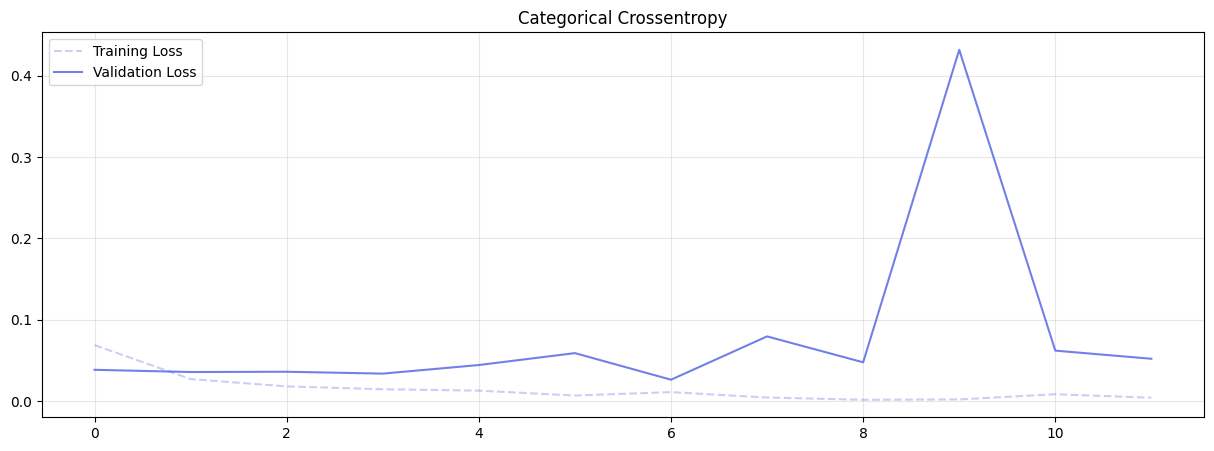

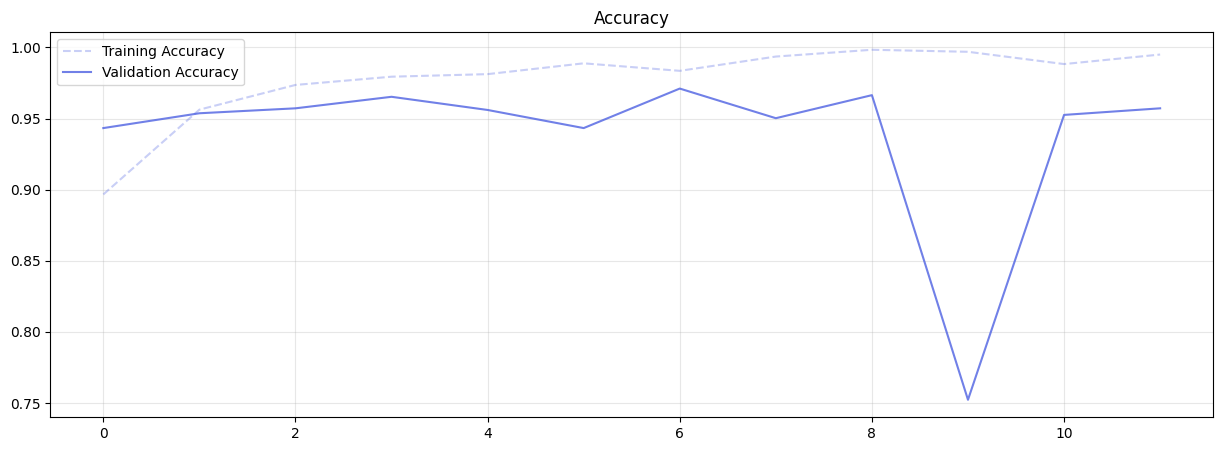

In [15]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history_transfer['loss'], label='Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_transfer['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history_transfer['accuracy'], label = 'Training Accuracy', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_transfer['val_accuracy'], label='Validation Accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [16]:
# Predict the test set with the CNN1
predictions = transfer_model.predict(test_generator)
label_names = {
    0: "N",
    1: "P",
    2: "T"
}
label_classes = label_names.values()
converted_test_labels = np.zeros(test_path_based["label"].shape)
converted_test_labels[test_path_based["label"] == 'N'] = 0
converted_test_labels[test_path_based["label"] == 'P'] = 1
converted_test_labels[test_path_based["label"] == 'T'] = 2 

34/34 [==============================] - 81s 2s/step


In [17]:
prediction_numerical = np.argmax(predictions, axis=-1)

Accuracy: 0.9653
Precision: 0.9487
Recall: 0.9582
F1: 0.9533


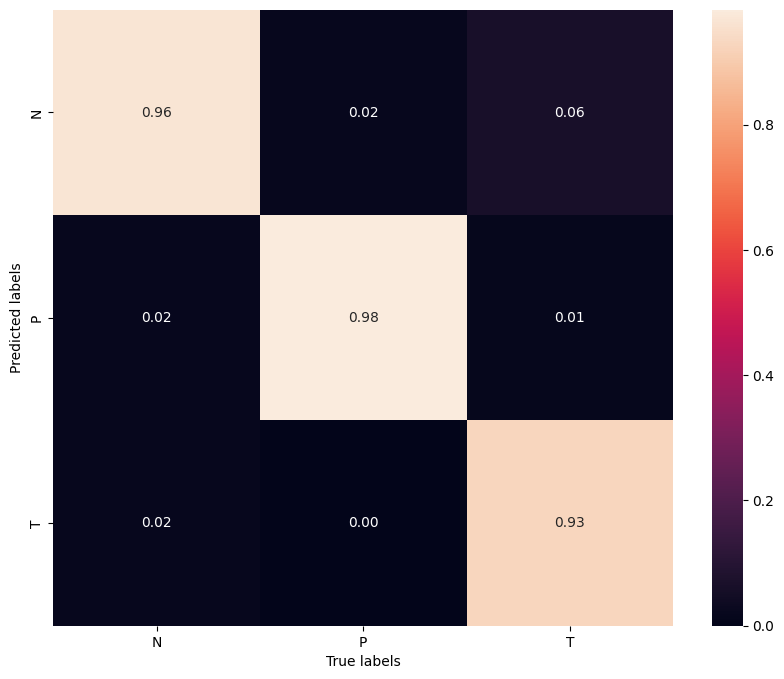

In [18]:
# Compute the confusion matrix
cm = confusion_matrix(converted_test_labels, np.argmax(predictions, axis=-1))
cm_rel = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Compute the classification metrics
accuracy = accuracy_score(converted_test_labels, np.argmax(predictions, axis=-1))
precision = precision_score(converted_test_labels, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(converted_test_labels, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(converted_test_labels, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_rel.T, xticklabels=label_classes, yticklabels=label_classes, annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [19]:
from sklearn.metrics import classification_report
# generate the classification report
print(classification_report(converted_test_labels, prediction_numerical, target_names=['Normal', 'Pneumonia', 'Tuberculosis']))

              precision    recall  f1-score   support

      Normal       0.98      0.96      0.97      1303
   Pneumonia       0.96      0.98      0.97       597
Tuberculosis       0.91      0.93      0.92       259

    accuracy                           0.97      2159
   macro avg       0.95      0.96      0.95      2159
weighted avg       0.97      0.97      0.97      2159



In [ ]:
print(tf.__version__)

Apparently, there is a bug with tensorflow versions >= 2.10.0 Efficientnet networks cannot be serialized. I need to retrain the model with tensorflow 2.9.0 to be able to export it.

In [20]:
transfer_model.save('DenseNet121-withoutAug')

In [21]:
!zip -r DenseNet121-withoutAug.zip /kaggle/working/Q-DenseNet-FTV2MedModel -r 

	zip warning: name not matched: /kaggle/working/Q-DenseNet-FTV2MedModel

zip error: Nothing to do! (try: zip -r -r DenseNet121-withoutAug.zip . -i /kaggle/working/Q-DenseNet-FTV2MedModel)


In [ ]:
x = pretrained_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.35)(x)
x = keras.layers.Dense(units = 128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
model_complete = keras.Model(pretrained_model.input, outputs)

model_complete.set_weights(transfer_model.get_weights())
model_complete.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), optimizer=tfa.optimizers.Yogi(1e-4), metrics='accuracy')
model_complete.summary()

In [ ]:
model_complete.save('DenseNet121-withoutAug_expanded')

In [ ]:
!zip -r DenseNet121-withoutAug_expanded.zip /kaggle/working/DenseNet121-withoutAug_expanded -r 